In [1]:
import json
import cv2
import PIL.Image as Image
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
import torch
import pickle

In [2]:
label_list = [i for i in os.listdir() if os.path.isdir(i) and 'label' in i]
image_list = [i for i in os.listdir() if os.path.isdir(i) and 'image' in i]

In [3]:
label_root = 'label_one'
image_root = 'image_one'
json_list= [i for i in os.listdir(label_root) if '.json' in i]
json_file = []
for js_name in json_list:
    with open(os.path.join(label_root,js_name),'r', encoding='utf8') as f:
        contents = f.read()
        json_data = json.loads(contents)
    json_file.append(json_data['label_info'])

In [4]:
def abstract_polygon(json_list,filter=None,factor = 0):
    '''
    polygon을 추출하는 함수입니다.
    arg1: json_list -> 파싱된 json 파일들이 들어갑니다.
    arg2: filter -> bright로 더 밝게, red로 더 빨갛게 필터를 넣을 수 있습니다.
    arg3: factor -> 얼마나 필터를 강하게 넣을지 선택합니다. 0~1 의 값이 적당한 것 같습니다.

    출력은 polygon_list를 크기를 딱 맞게 필터링해서 반환하게 됩니다.
    '''
    polygon_list = []
    factor = factor + 1
    print('abstract polygon from here : ' + image_root)
    for i in tqdm(json_list) :
        pt = i['shapes'][0]['points']
        lft = int(min(pt)[0])
        rig = int(max(pt)[0])
        tp = int(max(pt,key=lambda x:x[1])[1])
        bot = int(min(pt,key=lambda x:x[1])[1])
        width = i['image']['width']
        height = i['image']['height']
        polygon = np.array(pt,dtype=np.int32)
        empty_array = np.zeros((height,width,3),np.uint8)
        polygon = cv2.fillPoly(empty_array,[polygon],(255,255,255))
        image = cv2.imread(os.path.join(image_root,i['image']['file_name']))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if filter == 'bright':
            image = cv2.add(image,np.full(image.shape,(100*factor,100*factor,100*factor),dtype=np.uint8))
        if filter == 'red':
            image = cv2.add(image,np.full(image.shape,(100*factor,70/factor,70/factor),dtype=np.uint8))
        polygon2 = cv2.bitwise_and(image,polygon)
        polygon2 = polygon2[bot:tp,lft:rig,:].copy()
        polygon = polygon[bot:tp,lft:rig,:].copy()
        polygon_list.append([polygon2,polygon])
    return polygon_list


In [5]:
def image_conv(bg,fg):
    '''
    이미지 두개를 합성합니다.
    bg는 배경이 될 이미지를 의미합니다.
    fg는 abstract_polygon에서 반환된 값이 들어가면 됩니다.

    bg의 정 중앙에 fg가 맞게 합성된 이미지가 반환됩니다.
    '''
    bgw,bgh = bg.shape[:2]
    fgw,fgh = fg[0].shape[:2]
    bgw = int((bgw-fgw)/2)
    bgh = int((bgh-fgh)/2)
    roi = bg[bgw:bgw+fgw,bgh:bgh+fgh,:]
    mask = cv2.bitwise_not(fg[1])
    roi = cv2.bitwise_and(roi,mask)
    roi = cv2.add(roi,fg[0])
    bg[bgw:bgw+fgw,bgh:bgh+fgh,:] = roi
    return bg

In [6]:
polygon_list = abstract_polygon(json_file[:200])
#brighter = abstract_polygon(json_file,'bright')
#red = abstract_polygon(json_file,'red')

abstract polygon from here : image_one


100%|██████████| 200/200 [00:05<00:00, 33.85it/s]


In [7]:
'''
아직 배경에 맞는 이미지가 충분히 확보되지 않아서 임시로 하나만 넣어놨습니다. 
다같이 추가로 확보할 필요가 있을 것 같습니다.
'''
image = cv2.imread('plate.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(1024,1024))

In [8]:
count = 0

In [9]:
def separate_fat(poly): 
    meat= np.zeros(poly.shape,np.uint8)
    fat= np.zeros(poly.shape,np.uint8)
    for idx_y,val in enumerate(poly):
        for idx_x,(r,g,b) in enumerate(val):
            if (r > g*2) and (r > b*2):
                meat[idx_y][idx_x] = r,g,b
            else :
                fat[idx_y][idx_x] = r,g,b
    return meat, fat
    

In [30]:
def count_fat(poly):
    '''
    고기별 지방 / 살코기 분류
    '''
    meat= 0
    fat= 0
    for idx_y,val in enumerate(poly):
        for idx_x,(r,g,b) in enumerate(val):
            if (r > g*2) and (r > b*2):
                meat +=1
            elif r>1 or g>1 or b>1 :
                fat +=1
    return meat, fat

In [11]:
count = 0

지방 / 살코기 분리 시각화

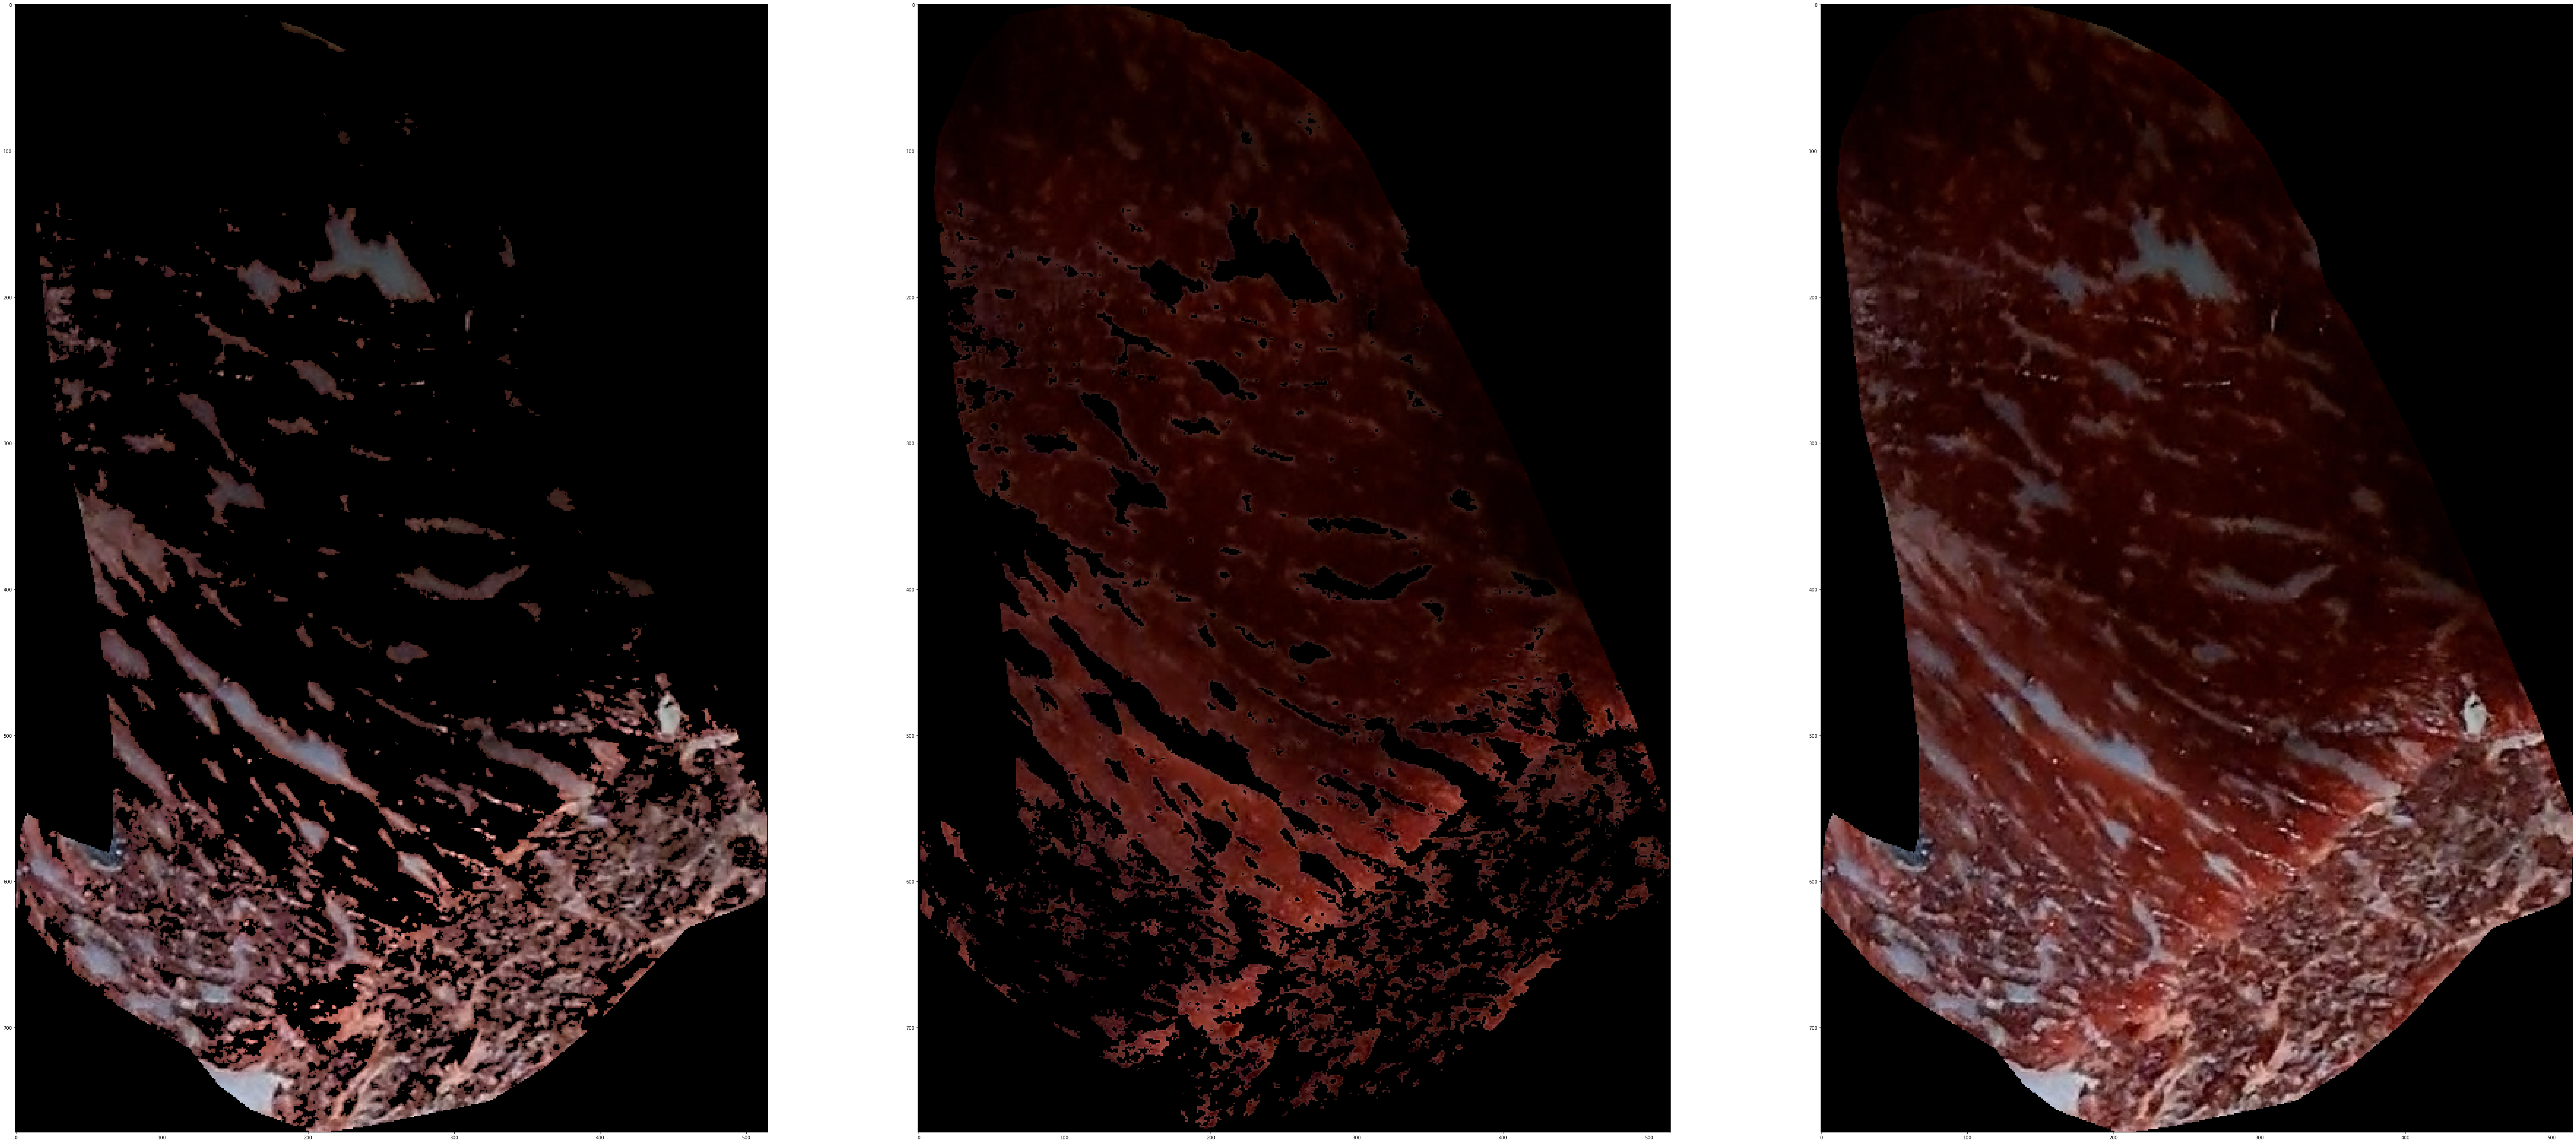

In [73]:
count = count+1
poly = polygon_list[count][0]
meat= np.zeros(poly.shape,np.uint8)
fat= np.zeros(poly.shape,np.uint8)
for idx_y,val in enumerate(poly):
    for idx_x,(r,g,b) in enumerate(val):
        if (r > g*2) and (r > b*2):
            meat[idx_y][idx_x] = r,g,b
        else :
            fat[idx_y][idx_x] = r,g,b

plt.figure(figsize=(100,100))
plt.subplot(1,3,1)
plt.imshow(fat)
plt.subplot(1,3,2)
#img = image_conv(image,polygon_list[count])
plt.imshow(meat)
plt.subplot(1,3,3)
plt.imshow(poly)

In [26]:
print(label_list)
print(image_list)
json_all = []
all_poly = []
for label,image in zip(label_list,image_list):
    label_root = label
    image_root = image
    json_list= [i for i in os.listdir(label_root) if '.json' in i]
    json_file = []
    for js_name in json_list:
        with open(os.path.join(label_root,js_name),'r', encoding='utf8') as f:
            contents = f.read()
            json_data = json.loads(contents)
        json_file.append(json_data['label_info'])
    poly = abstract_polygon(json_file[:500])
    json_all.append(json_file)
    all_poly.append({'class':label[6:], 'polygon':poly})


['label_one', 'label_onep', 'label_onepp', 'label_three', 'label_two']
['image_one', 'image_onep', 'image_onepp', 'image_three', 'image_two']
abstract polygon from here : image_one


100%|██████████| 500/500 [00:15<00:00, 31.79it/s]


abstract polygon from here : image_onep


100%|██████████| 500/500 [00:15<00:00, 31.32it/s]


abstract polygon from here : image_onepp


100%|██████████| 500/500 [00:16<00:00, 30.29it/s]


abstract polygon from here : image_three


100%|██████████| 500/500 [00:11<00:00, 44.38it/s]


abstract polygon from here : image_two


100%|██████████| 500/500 [00:14<00:00, 35.24it/s]


각 이미지별 표본수

In [14]:
for i in json_all:
    print(len(i))

2141
2269
2478
539
1252


In [15]:
device = torch.device('cuda')

In [16]:
len(all_poly[0]['polygon'])

400

In [31]:
'''
fat_meat = []
for i in all_poly:
    fm = []
    print('calculating ratio of fat of : ' + i['class'])
    for j in tqdm(i['polygon']):
        fat,meat = count_fat(j[0])
        fm.append([fat,meat])
    fat_meat.append({'val':fm,'class':i['class']})

with open('fatRatio2.pickle','wb') as f:
    pickle.dump(fat_meat,f)
'''


calculating ratio of fat of : one


100%|██████████| 500/500 [27:04<00:00,  3.25s/it]


calculating ratio of fat of : onep


100%|██████████| 500/500 [26:05<00:00,  3.13s/it]


calculating ratio of fat of : onepp


100%|██████████| 500/500 [27:37<00:00,  3.31s/it]


calculating ratio of fat of : three


100%|██████████| 500/500 [22:58<00:00,  2.76s/it]


calculating ratio of fat of : two


100%|██████████| 500/500 [26:35<00:00,  3.19s/it]


In [18]:
with open('fatRatio2.pickle','rb') as f:
    fat_meat = pickle.load(f)

평균

In [35]:

for i in fat_meat:
    avg = 0
    div = 500
    for j in i['val']:
        if((j[0]+j[1])>1):
            avg+= j[1]/(j[0]+j[1])
        else:
            div-=1
    print('class : '+ i['class'] +' fat ratio : '+str(avg/div))

class : one fat ratio : 0.39269228064165407
class : onep fat ratio : 0.41349325619654603
class : onepp fat ratio : 0.4292907354087129
class : three fat ratio : 0.3134133858793345
class : two fat ratio : 0.3729932561571693


중앙값

In [74]:
import statistics

for i in fat_meat:
    avg = 0
    lst=[]
    for j in i['val']:
        if((j[0]+j[1])>1):
            lst.append(j[1]/(j[0]+j[1]))
        else:
            pass
    print('class : '+ i['class'] +' median : '+str(statistics.median(lst)))

class : one median : 0.3627926547006134
class : onep median : 0.3978280630036768
class : onepp median : 0.40812271783489656
class : three median : 0.287307174545373
class : two median : 0.34411775767579894


In [104]:
import statistics

for i in fat_meat:
    avg = 0
    lst=[]
    for j in i['val']:
        if((j[0]+j[1])>1):
            lst.append(j[1]/(j[0]+j[1]))
        else:
            pass
    print('class : '+ i['class'] +' 표준편차 : '+str(statistics.stdev(lst)))

class : one 표준편차 : 0.16952374094935807
class : onep 표준편차 : 0.16640280746187805
class : onepp 표준편차 : 0.1784973953696831
class : three 표준편차 : 0.1483476858029029
class : two 표준편차 : 0.16663418949135797


In [103]:
import statistics

for i in fat_meat:
    avg = 0
    lst=[]
    for j in i['val']:
        if((j[0]+j[1])>1):
            lst.append(j[1]/(j[0]+j[1]))
        else:
            pass
    print('class : '+ i['class'] +' 분산 : '+str(statistics.variance(lst)))

class : one 분산 : 0.028738298745465064
class : onep 분산 : 0.02768989433119486
class : onepp 분산 : 0.03186132015376096
class : three 분산 : 0.022007035883076793
class : two 분산 : 0.027766953107441796


In [45]:
fat_meat[0]['val'][0][0]
fat_meat[0]['val'][0][1]

76125

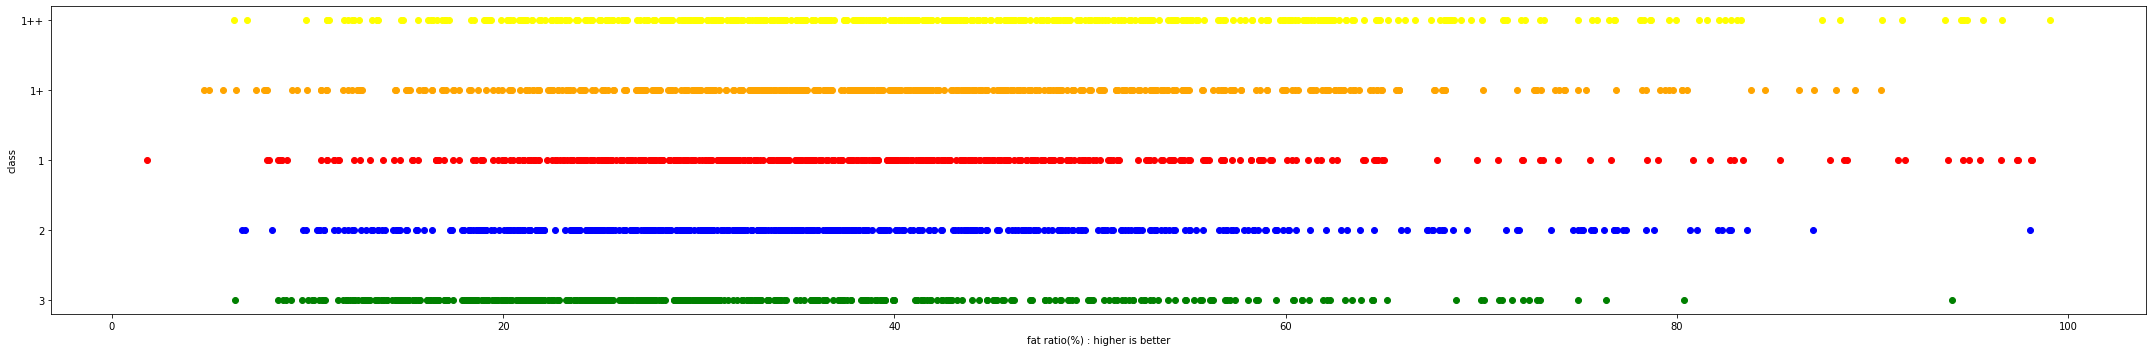

In [67]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(30,5))
colors = ['red','orange','yellow','green','blue']
ct = 0
for i in fat_meat:
    if(i['class']=='onepp'):
        qq = 4
    elif (i['class']=='onep'):
        qq = 3
    elif (i['class']=='one'):
        qq = 2
    elif (i['class']=='two'):
        qq = 1
    else:
        qq = 0
    for j in i['val']:
        sum = j[0]+j[1]
        if(sum>1):
            Y = j[1] / sum *100
            ax.scatter(Y,qq,color = colors[ct])
        else:
            pass
    ct +=1
plt.yticks([0,1,2,3,4],labels=['3','2','1','1+','1++'])
plt.xlabel('fat ratio(%) : higher is better')
plt.ylabel('class')
plt.tight_layout()
plt.show()

In [79]:

import matplotlib.pyplot as plt

avvg = []
for i in fat_meat:
    avgi=[]
    for j in i['val']:
        sum = j[0]+j[1]
        if(sum>1):
            Y = j[1] / sum *100
            avgi.append(Y)
        else:
            pass
    avvg.append(avgi)


In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
df = pd.DataFrame(avvg).transpose()
df2 = pd.DataFrame(avvg)

D:\miniconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\miniconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\miniconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

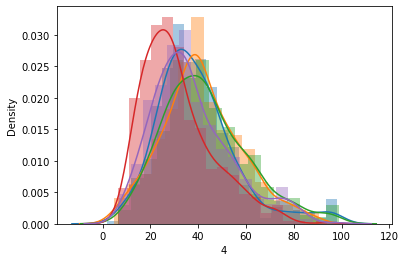

In [99]:
sns.displot()

D:\miniconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='3', ylabel='Density'>

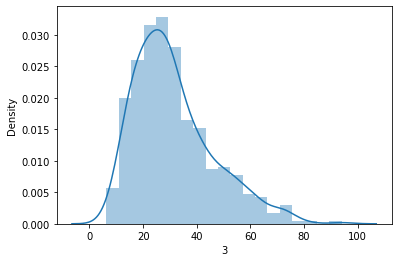

In [102]:
sns.distplot(df[3])